# Load SUPPORT dataset

- fill values are found in the table below

Baseline Variable | Column Name | Normal Fill-in Value
--- | --- | ---
Serum albumin | alb | 3.5
PaO2/FiO2 ratio (pafi) | pafi | 333.3
Bilirubin | bili | 1.01
Creatinine | crea | 1.01
BUN | bun | 6.51
White blood count | wblc | 9 (thousands)
Urine output | urine | 2502

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../src')
from models import DNMC, NMC, NSurv, MLP, discrete_ci

import tensorflow as tf
from tensorflow import keras

tf.random.set_seed(2021)

In [2]:
FILL_VALUES = {
    'alb': 3.5,
    'pafi': 333.3,
    'bili': 1.01,
    'crea': 1.01,
    'bun': 6.51,
    'wblc': 9.,
    'urine': 2502.
}

TO_DROP = ['aps', 'sps', 'surv2m', 'surv6m', 'prg2m', 'prg6m', 'dnr', 'dnrday']
TO_DROP = TO_DROP + ['sfdm2', 'hospdead']

# load, drop columns, fill using specified fill values
df = pd.read_csv('../datasets/support2.csv').drop(TO_DROP,axis=1).fillna(value=FILL_VALUES)

# get dummies for categorical vars
df = pd.get_dummies(df, dummy_na=True)

# fill remaining values to the median

df = df.fillna(df.median())

# standardize numeric columns

numrc_cols = df.dtypes == 'float64'
df.loc[:, numrc_cols] = (df.loc[:, numrc_cols] - df.loc[:, numrc_cols].mean()) / df.loc[:, numrc_cols].std()

df

,age,death,slos,d.time,num.co,edu,scoma,charges,totcst,totmcst,...,race_asian,race_black,race_hispanic,race_other,race_white,race_nan,ca_metastatic,ca_no,ca_yes,ca_nan
1,0.012772,0,5,2029,0,-0.253787,-0.489421,-0.487495,-0.337656,-0.274795,...,0,0,0,1,0,0,1,0,0,0
2,-0.148254,1,4,4,2,0.066259,1.296607,-0.244033,-0.337656,-0.274795,...,0,0,0,0,1,0,0,1,0,0
3,-0.635118,1,17,47,2,0.066259,-0.489421,-0.179211,-0.337656,-0.274795,...,0,0,0,0,1,0,0,1,0,0
4,-1.299617,1,3,133,2,-0.253787,-0.489421,-0.552730,-0.337656,-0.274795,...,0,0,0,0,1,0,1,0,0,0
5,1.105197,0,16,2029,1,0.066259,0.565959,-0.090466,-0.337656,-0.274795,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9101,0.219459,0,23,350,1,-1.213925,-0.489421,-0.063517,0.116548,0.261135,...,0,0,0,0,1,0,0,1,0,0
9102,-0.480760,0,29,347,1,-0.253787,1.174832,-0.235378,-0.129578,-0.021128,...,0,0,0,0,1,0,0,1,0,0
9103,0.495786,0,8,346,1,0.066259,-0.489421,-0.125471,0.049816,0.235178,...,0,0,0,0,1,0,0,1,0,0
9104,-1.002381,1,7,7,1,0.386305,-0.489421,-0.008804,-0.337656,-0.274795,...,0,0,0,0,1,0,0,0,1,0


In [3]:
df['death'].value_counts()

1    6201
0    2904
Name: death, dtype: int64

In [4]:
OUTCOMES = ['death', 'd.time']
X = df.drop(OUTCOMES, axis=1).sample(frac=1, random_state=2021)
X = X.values

## We create the semi-synthetic dataset as follows

- real X

- make up new failure times
- make up new failure probabilities
- make up new censoring times

In [5]:
# GLOBAL PARAMETERS

N_FEATURES = 10
N_BINS = 10
LEARNING_RATE = 6e-4
N_OVERLAPPING = 5

rs = np.random.RandomState(8)

## Separate Factors

- randomly select separate factors for failure times vs probabilities (no overlap)
- censoring times are random uniform

In [6]:
def discretize(*arrs, nbins=10, pad=1e-5):
    min_val = np.amin(np.stack(arrs))
    max_val = np.amax(np.stack(arrs))
    binsize = (max_val - min_val + pad) / nbins
    return ((arr - arr.min()) // binsize for arr in arrs)
    
def onehot(arr, ncategories=None):
    if ncategories is None:
        ncategories = len(np.unique(arr))
    return np.eye(ncategories)[arr.astype(int)]

In [7]:
feature_order = rs.permutation(len(X.T))
T_features = feature_order[:N_FEATURES]
E_features = feature_order[N_FEATURES:(2 * N_FEATURES)]

T_weights = rs.randn(len(T_features))
E_weights = rs.randn(len(E_features))

T = X[:, T_features] @ T_weights
E = X[:, E_features] @ E_weights

t_cont = np.exp((T - np.mean(T)) / (2 * np.std(T)))
c_cont = rs.rand(len(t_cont)) * t_cont.max()

e_prob = 1 - 1 / (1 + np.exp(4. * (E - E.mean()) / E.std()))
e = (rs.rand(len(e_prob)) < e_prob).astype(int)

ct_cont = np.stack([c_cont, t_cont]).T
y_cont = e * np.amin(ct_cont, axis=1) + (1 - e) * c_cont

s = e * np.argmin(ct_cont, axis=1)
y_disc, t_disc, c_disc = discretize(y_cont, t_cont, c_cont, nbins=N_BINS)

y = onehot(y_disc, ncategories=N_BINS)

How many are susceptible?
0    4679
1    4426
dtype: int64
How many are observed?
0    6871
1    2234
dtype: int64


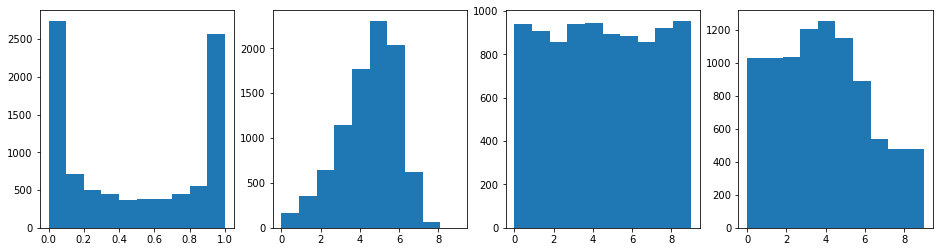

In [8]:
print('How many are susceptible?')
print(pd.value_counts(e).sort_index())

print('How many are observed?')
print(pd.value_counts(s).sort_index())

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))

ax[0].hist(e_prob)
ax[1].hist(t_disc)
ax[2].hist(c_disc)
ax[3].hist(y_disc)

plt.show()

In [9]:
x_train, y_train, s_train = X[:6000], y[:6000], s[:6000]
x_val, y_val, s_val = X[6000:7500], y[6000:7500], s[6000:7500]
x_test, y_test, s_test, e_test = X[7500:], y[7500:], s[7500:], e[7500:]
t_disc_test, c_disc_test, y_disc_test = t_disc[7500:], c_disc[7500:], y_disc[7500:]

In [10]:
def get_batches(*arrs, batch_size=1):
    l = len(arrs[0])
    for ndx in range(0, l, batch_size):
        yield (arr[ndx:min(ndx + batch_size, l)] for arr in arrs)
        
import time

def train_model(
    model, train_data, val_data, n_epochs,
    batch_size=50, learning_rate=1e-3, early_stopping_criterion=2):

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    #@tf.function
    def train_step(x, y, s):
        with tf.GradientTape() as tape:
            train_loss, train_nll = model.loss(x, y, s)
            #print(train_loss, train_nll)
        grads = tape.gradient(train_loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        return train_loss, train_nll

    #@tf.function
    def test_step(x, y, s):
        val_loss, val_nll = model.loss(x, y, s)
        return val_loss, val_nll
    
    best_val_loss = np.inf
    no_decrease = 0

    for epoch_idx in range(n_epochs):

        #print("\nStart of epoch %d" % (epoch_idx,))
        start_time = time.time()

        train_losses = []
        train_nlls = []

        for batch_idx, (xt, yt, st) in enumerate(get_batches(*train_data, batch_size=batch_size)):

            train_loss, train_nll = train_step(xt, yt, st)

            train_losses.append(train_loss)
            train_nlls.append(train_nll)

        # Display metrics at the end of each epoch.
        #print('Epoch training loss: %.4f, NLL = %.4f' % (np.mean(batch_losses), np.mean(batch_nll)))

        val_losses = []
        val_nlls = []

        # Run a validation loop at the end of each epoch.
        for batch_idx, (xv, yv, sv) in enumerate(get_batches(*val_data, batch_size=batch_size)):

            val_loss, val_nll = test_step(xv, yv, sv)

            val_losses.append(val_loss)
            val_nlls.append(val_nll)
            
        new_val_loss = np.mean(val_losses)

        print(
            'Epoch %2i | Train Loss: %.4f | Train NLL: %.4f | Val Loss: %.4f | Val NLL: %.4f'
            % (epoch_idx, np.mean(train_losses), np.mean(train_nlls), np.mean(val_losses), np.mean(val_nlls))
        )
        #print('Time taken: %.2fs' % (time.time() - start_time))
                
        if new_val_loss > best_val_loss:
            no_decrease += 1
        else:
            no_decrease = 0
            best_val_loss = new_val_loss
            
        if no_decrease == early_stopping_criterion:
            break

In [11]:
from sklearn.metrics import roc_auc_score


def nll(t_true, t_pred, tol=1e-8):
    ncat = np.shape(t_pred)[1]
    nll_ = -1 * np.log(np.sum(onehot(t_true, ncategories=ncat) * t_pred, axis=1) + tol)
    return np.mean(nll_)


def evaluate_model(
    model, test_data, e_test, 
    batch_size=50, dataset='support', factors='unknown'):
    
    modelname = type(model).__name__
    
    test_losses = []
    test_nlls = []
    
    test_e_pred = []
    test_t_pred = []
    test_c_pred = []
    
    for batch_idx, (xt, yt, st) in enumerate(get_batches(*test_data, batch_size=batch_size)):
        
        test_loss, test_nll = model.loss(xt, yt, st)
        
        if modelname == 'NSurv':
            t_pred, c_pred = model(xt)
            test_t_pred.append(t_pred)
            test_c_pred.append(c_pred)
        elif modelname == 'MLP':
            e_pred = model(xt)
            test_e_pred.append(e_pred)
        else:
            e_pred, t_pred, c_pred = model(xt)
            test_e_pred.append(e_pred)
            test_t_pred.append(t_pred)
            test_c_pred.append(c_pred)
        
        test_losses.append(test_loss)
        test_nlls.append(test_nll)
    
    if modelname == 'NSurv':
        e_auc = None
    else:
        e_auc = roc_auc_score(e_test, np.concatenate(test_e_pred, axis=0))
        
    if modelname == 'MLP':
        ci = None
    else:
        ci = discrete_ci(test_data[2], test_data[1], np.concatenate(test_t_pred, axis=0))
    
    results = {
        'dataset': dataset,
        'factors': factors,
        'model': modelname,
        'ld': model.ld,
        'lr': model.lr,
        'avg_test_loss': np.mean(test_losses),
        'avg_test_nll': np.mean(test_nlls),
        'e_auc': e_auc,
        'y_ci': ci
    }
    
    return results

In [12]:
### BEGIN COLLECTING RESULTS HERE ###
all_results = []

pstrue = s_train.mean()
importance_weights = [1 / (1 - pstrue), 1 / pstrue]

In [13]:
model = DNMC(n_bins=N_BINS, importance_weights=importance_weights, ld=1e-2, lr=1e-2)
train_model(model, (x_train, y_train, s_train), (x_val, y_val, s_val), 100, learning_rate=LEARNING_RATE)
all_results.append(evaluate_model(model, (x_test, y_test, s_test), e_test, factors='separate'))

Epoch  0 | Train Loss: 13.9172 | Train NLL: 5.5904 | Val Loss: 10.5537 | Val NLL: 5.0827
Epoch  1 | Train Loss: 9.2163 | Train NLL: 4.7749 | Val Loss: 8.2689 | Val NLL: 4.5612
Epoch  2 | Train Loss: 7.6559 | Train NLL: 4.3681 | Val Loss: 7.4372 | Val NLL: 4.4988
Epoch  3 | Train Loss: 6.9204 | Train NLL: 4.2359 | Val Loss: 6.7307 | Val NLL: 4.2785
Epoch  4 | Train Loss: 6.3495 | Train NLL: 4.0746 | Val Loss: 6.1990 | Val NLL: 4.0909
Epoch  5 | Train Loss: 5.9564 | Train NLL: 3.9811 | Val Loss: 6.0250 | Val NLL: 4.1787
Epoch  6 | Train Loss: 5.6660 | Train NLL: 3.9211 | Val Loss: 5.5618 | Val NLL: 3.9200
Epoch  7 | Train Loss: 5.4005 | Train NLL: 3.8390 | Val Loss: 5.3929 | Val NLL: 3.9156
Epoch  8 | Train Loss: 5.1757 | Train NLL: 3.7657 | Val Loss: 5.1380 | Val NLL: 3.7994
Epoch  9 | Train Loss: 5.0133 | Train NLL: 3.7320 | Val Loss: 5.0044 | Val NLL: 3.7828
Epoch 10 | Train Loss: 4.8922 | Train NLL: 3.7179 | Val Loss: 4.9203 | Val NLL: 3.7961
Epoch 11 | Train Loss: 4.7428 | Train NLL

In [14]:
model = DNMC(n_bins=N_BINS, importance_weights=importance_weights, ld=3e-3, lr=1e-2)
train_model(model, (x_train, y_train, s_train), (x_val, y_val, s_val), 100, learning_rate=LEARNING_RATE)
all_results.append(evaluate_model(model, (x_test, y_test, s_test), e_test, factors='separate'))

Epoch  0 | Train Loss: 13.6376 | Train NLL: 5.5189 | Val Loss: 9.9465 | Val NLL: 4.8506
Epoch  1 | Train Loss: 8.8644 | Train NLL: 4.7892 | Val Loss: 8.0929 | Val NLL: 4.7001
Epoch  2 | Train Loss: 7.4814 | Train NLL: 4.4601 | Val Loss: 7.2880 | Val NLL: 4.5859
Epoch  3 | Train Loss: 6.7107 | Train NLL: 4.2361 | Val Loss: 6.5416 | Val NLL: 4.2725
Epoch  4 | Train Loss: 6.1718 | Train NLL: 4.0594 | Val Loss: 6.0588 | Val NLL: 4.0966
Epoch  5 | Train Loss: 5.7749 | Train NLL: 3.9327 | Val Loss: 5.7371 | Val NLL: 4.0118
Epoch  6 | Train Loss: 5.5308 | Train NLL: 3.8940 | Val Loss: 5.5086 | Val NLL: 3.9643
Epoch  7 | Train Loss: 5.2761 | Train NLL: 3.8051 | Val Loss: 5.3341 | Val NLL: 3.9380
Epoch  8 | Train Loss: 5.0984 | Train NLL: 3.7639 | Val Loss: 5.1436 | Val NLL: 3.8732
Epoch  9 | Train Loss: 4.9375 | Train NLL: 3.7169 | Val Loss: 5.0215 | Val NLL: 3.8543
Epoch 10 | Train Loss: 4.8157 | Train NLL: 3.6910 | Val Loss: 4.8897 | Val NLL: 3.8090
Epoch 11 | Train Loss: 4.7073 | Train NLL:

In [15]:
model = DNMC(n_bins=N_BINS, importance_weights=importance_weights, ld=3e-2, lr=1e-2)
train_model(model, (x_train, y_train, s_train), (x_val, y_val, s_val), 100, learning_rate=LEARNING_RATE)
all_results.append(evaluate_model(model, (x_test, y_test, s_test), e_test, factors='separate'))

Epoch  0 | Train Loss: 13.5269 | Train NLL: 5.5548 | Val Loss: 10.1672 | Val NLL: 5.1312
Epoch  1 | Train Loss: 8.8493 | Train NLL: 4.7855 | Val Loss: 8.0847 | Val NLL: 4.6894
Epoch  2 | Train Loss: 7.4177 | Train NLL: 4.3983 | Val Loss: 7.0742 | Val NLL: 4.3698
Epoch  3 | Train Loss: 6.6537 | Train NLL: 4.1763 | Val Loss: 6.4546 | Val NLL: 4.1875
Epoch  4 | Train Loss: 6.1797 | Train NLL: 4.0640 | Val Loss: 6.0553 | Val NLL: 4.0916
Epoch  5 | Train Loss: 5.7858 | Train NLL: 3.9465 | Val Loss: 5.7675 | Val NLL: 4.0476
Epoch  6 | Train Loss: 5.4804 | Train NLL: 3.8568 | Val Loss: 5.4841 | Val NLL: 3.9539
Epoch  7 | Train Loss: 5.2372 | Train NLL: 3.7869 | Val Loss: 5.2101 | Val NLL: 3.8405
Epoch  8 | Train Loss: 5.0418 | Train NLL: 3.7356 | Val Loss: 5.0440 | Val NLL: 3.8015
Epoch  9 | Train Loss: 4.8895 | Train NLL: 3.7004 | Val Loss: 4.8964 | Val NLL: 3.7626
Epoch 10 | Train Loss: 4.7592 | Train NLL: 3.6702 | Val Loss: 4.7860 | Val NLL: 3.7444
Epoch 11 | Train Loss: 4.6614 | Train NLL

In [16]:
model = NMC(n_bins=N_BINS, importance_weights=importance_weights, lr=1e-2)
train_model(model, (x_train, y_train, s_train), (x_val, y_val, s_val), 100, learning_rate=LEARNING_RATE)
all_results.append(evaluate_model(model, (x_test, y_test, s_test), e_test, factors='separate'))

Epoch  0 | Train Loss: 12.2385 | Train NLL: 5.3304 | Val Loss: 9.2848 | Val NLL: 4.7426
Epoch  1 | Train Loss: 8.2173 | Train NLL: 4.6215 | Val Loss: 7.3261 | Val NLL: 4.4022
Epoch  2 | Train Loss: 6.9008 | Train NLL: 4.3458 | Val Loss: 6.5140 | Val NLL: 4.2632
Epoch  3 | Train Loss: 6.2406 | Train NLL: 4.1997 | Val Loss: 6.0121 | Val NLL: 4.1567
Epoch  4 | Train Loss: 5.7983 | Train NLL: 4.0846 | Val Loss: 5.6558 | Val NLL: 4.0739
Epoch  5 | Train Loss: 5.4813 | Train NLL: 4.0038 | Val Loss: 5.3768 | Val NLL: 4.0001
Epoch  6 | Train Loss: 5.2853 | Train NLL: 3.9880 | Val Loss: 5.1684 | Val NLL: 3.9492
Epoch  7 | Train Loss: 5.0823 | Train NLL: 3.9271 | Val Loss: 5.0538 | Val NLL: 3.9607
Epoch  8 | Train Loss: 4.9007 | Train NLL: 3.8600 | Val Loss: 4.8421 | Val NLL: 3.8554
Epoch  9 | Train Loss: 4.7976 | Train NLL: 3.8538 | Val Loss: 4.8458 | Val NLL: 3.9445
Epoch 10 | Train Loss: 4.7178 | Train NLL: 3.8505 | Val Loss: 4.6583 | Val NLL: 3.8298
Epoch 11 | Train Loss: 4.6079 | Train NLL:

In [17]:
model = NSurv(n_bins=N_BINS, importance_weights=importance_weights, lr=1e-2)
train_model(model, (x_train, y_train, s_train), (x_val, y_val, s_val), 100, learning_rate=LEARNING_RATE)
all_results.append(evaluate_model(model, (x_test, y_test, s_test), e_test, factors='separate'))

Epoch  0 | Train Loss: 10.3683 | Train NLL: 5.4280 | Val Loss: 8.4810 | Val NLL: 4.9561
Epoch  1 | Train Loss: 7.6371 | Train NLL: 4.7348 | Val Loss: 7.1020 | Val NLL: 4.6617
Epoch  2 | Train Loss: 6.6410 | Train NLL: 4.4645 | Val Loss: 6.4124 | Val NLL: 4.4604
Epoch  3 | Train Loss: 6.1072 | Train NLL: 4.3105 | Val Loss: 6.0098 | Val NLL: 4.3556
Epoch  4 | Train Loss: 5.7368 | Train NLL: 4.1894 | Val Loss: 5.7108 | Val NLL: 4.2658
Epoch  5 | Train Loss: 5.4657 | Train NLL: 4.0999 | Val Loss: 5.3946 | Val NLL: 4.1079
Epoch  6 | Train Loss: 5.2492 | Train NLL: 4.0246 | Val Loss: 5.1707 | Val NLL: 4.0100
Epoch  7 | Train Loss: 5.0769 | Train NLL: 3.9660 | Val Loss: 5.0257 | Val NLL: 3.9674
Epoch  8 | Train Loss: 4.9398 | Train NLL: 3.9224 | Val Loss: 4.9019 | Val NLL: 3.9289
Epoch  9 | Train Loss: 4.8237 | Train NLL: 3.8856 | Val Loss: 4.8074 | Val NLL: 3.9076
Epoch 10 | Train Loss: 4.7278 | Train NLL: 3.8573 | Val Loss: 4.7208 | Val NLL: 3.8837
Epoch 11 | Train Loss: 4.6397 | Train NLL:

In [18]:
model = MLP(importance_weights=importance_weights, lr=1e-2)
train_model(model, (x_train, y_train, s_train), (x_val, y_val, s_val), 100, learning_rate=LEARNING_RATE)
all_results.append(evaluate_model(model, (x_test, y_test, s_test), e_test, factors='separate'))

Epoch  0 | Train Loss: 3.5809 | Train NLL: 1.2390 | Val Loss: 2.6526 | Val NLL: 1.0909
Epoch  1 | Train Loss: 2.3427 | Train NLL: 1.1014 | Val Loss: 2.0575 | Val NLL: 1.0434
Epoch  2 | Train Loss: 1.9639 | Train NLL: 1.0739 | Val Loss: 1.8125 | Val NLL: 1.0253
Epoch  3 | Train Loss: 1.7687 | Train NLL: 1.0528 | Val Loss: 1.6645 | Val NLL: 1.0119
Epoch  4 | Train Loss: 1.6443 | Train NLL: 1.0410 | Val Loss: 1.5665 | Val NLL: 1.0082
Epoch  5 | Train Loss: 1.5485 | Train NLL: 1.0267 | Val Loss: 1.4888 | Val NLL: 1.0010
Epoch  6 | Train Loss: 1.4698 | Train NLL: 1.0110 | Val Loss: 1.4278 | Val NLL: 0.9958
Epoch  7 | Train Loss: 1.4088 | Train NLL: 1.0002 | Val Loss: 1.3757 | Val NLL: 0.9893
Epoch  8 | Train Loss: 1.3615 | Train NLL: 0.9944 | Val Loss: 1.3345 | Val NLL: 0.9856
Epoch  9 | Train Loss: 1.3317 | Train NLL: 0.9991 | Val Loss: 1.3196 | Val NLL: 1.0021
Epoch 10 | Train Loss: 1.2856 | Train NLL: 0.9822 | Val Loss: 1.2736 | Val NLL: 0.9842
Epoch 11 | Train Loss: 1.2546 | Train NLL: 

## Overlapping Factors

In [19]:
feature_order = rs.permutation(len(X.T))
T_features = feature_order[N_OVERLAPPING:(N_FEATURES + N_OVERLAPPING)]
E_features = feature_order[N_FEATURES:(2 * N_FEATURES)]

T_weights = rs.randn(len(T_features))
E_weights = rs.randn(len(E_features))

T = X[:, T_features] @ T_weights
E = X[:, E_features] @ E_weights

t_cont = np.exp((T - np.mean(T)) / (2 * np.std(T)))
c_cont = rs.rand(len(t_cont)) * t_cont.max()

e_prob = 1 - 1 / (1 + np.exp(4. * (E - E.mean()) / E.std()))
e = (rs.rand(len(e_prob)) < e_prob).astype(int)

ct_cont = np.stack([c_cont, t_cont]).T
y_cont = e * np.amin(ct_cont, axis=1) + (1 - e) * c_cont

s = e * np.argmin(ct_cont, axis=1)
y_disc, t_disc, c_disc = discretize(y_cont, t_cont, c_cont, nbins=N_BINS)

y = onehot(y_disc, ncategories=N_BINS)

In [20]:
pstrue = s_train.mean()
importance_weights = [1 / (1 - pstrue), 1 / pstrue]

How many are susceptible?
0    5107
1    3998
dtype: int64
How many are observed?
0    5948
1    3157
dtype: int64


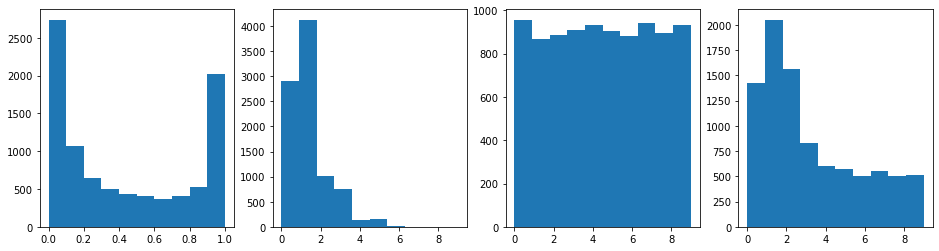

In [21]:
print('How many are susceptible?')
print(pd.value_counts(e).sort_index())

print('How many are observed?')
print(pd.value_counts(s).sort_index())

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))

ax[0].hist(e_prob)
ax[1].hist(t_disc)
ax[2].hist(c_disc)
ax[3].hist(y_disc)

plt.show()

In [22]:
x_train, y_train, s_train = X[:6000], y[:6000], s[:6000]
x_val, y_val, s_val = X[6000:7500], y[6000:7500], s[6000:7500]
x_test, y_test, s_test, e_test = X[7500:], y[7500:], s[7500:], e[7500:]
t_disc_test, c_disc_test, y_disc_test = t_disc[7500:], c_disc[7500:], y_disc[7500:]

In [23]:
x_train.shape, y_train.shape, s_train.shape, x_val.shape, y_val.shape, s_val.shape

((6000, 61), (6000, 10), (6000,), (1500, 61), (1500, 10), (1500,))

In [24]:
model = DNMC(n_bins=N_BINS, importance_weights=importance_weights, ld=1e-2, lr=1e-2)
train_model(model, (x_train, y_train, s_train), (x_val, y_val, s_val), 100, learning_rate=LEARNING_RATE)
all_results.append(evaluate_model(model, (x_test, y_test, s_test), e_test, factors='overlapping'))

Epoch  0 | Train Loss: 13.7682 | Train NLL: 5.3611 | Val Loss: 10.3853 | Val NLL: 4.8976
Epoch  1 | Train Loss: 8.9239 | Train NLL: 4.5424 | Val Loss: 8.0021 | Val NLL: 4.4032
Epoch  2 | Train Loss: 7.3707 | Train NLL: 4.2129 | Val Loss: 7.0328 | Val NLL: 4.2411
Epoch  3 | Train Loss: 6.5846 | Train NLL: 4.0388 | Val Loss: 6.3813 | Val NLL: 4.0536
Epoch  4 | Train Loss: 6.0580 | Train NLL: 3.9018 | Val Loss: 5.9021 | Val NLL: 3.8984
Epoch  5 | Train Loss: 5.6396 | Train NLL: 3.7575 | Val Loss: 5.5774 | Val NLL: 3.8085
Epoch  6 | Train Loss: 5.3754 | Train NLL: 3.6995 | Val Loss: 5.3342 | Val NLL: 3.7459
Epoch  7 | Train Loss: 5.1288 | Train NLL: 3.6121 | Val Loss: 5.1042 | Val NLL: 3.6597
Epoch  8 | Train Loss: 4.9263 | Train NLL: 3.5400 | Val Loss: 4.9598 | Val NLL: 3.6328
Epoch  9 | Train Loss: 4.7727 | Train NLL: 3.4962 | Val Loss: 4.8555 | Val NLL: 3.6286
Epoch 10 | Train Loss: 4.6422 | Train NLL: 3.4568 | Val Loss: 4.7015 | Val NLL: 3.5573
Epoch 11 | Train Loss: 4.5146 | Train NLL

In [25]:
model = DNMC(n_bins=N_BINS, importance_weights=importance_weights, ld=3e-3, lr=1e-2)
train_model(model, (x_train, y_train, s_train), (x_val, y_val, s_val), 100, learning_rate=LEARNING_RATE)
all_results.append(evaluate_model(model, (x_test, y_test, s_test), e_test, factors='overlapping'))

Epoch  0 | Train Loss: 13.3943 | Train NLL: 5.3226 | Val Loss: 9.7018 | Val NLL: 4.7326
Epoch  1 | Train Loss: 8.3886 | Train NLL: 4.4814 | Val Loss: 7.5384 | Val NLL: 4.3448
Epoch  2 | Train Loss: 6.9283 | Train NLL: 4.1144 | Val Loss: 6.5572 | Val NLL: 4.0548
Epoch  3 | Train Loss: 6.2297 | Train NLL: 3.9423 | Val Loss: 6.0897 | Val NLL: 3.9920
Epoch  4 | Train Loss: 5.7478 | Train NLL: 3.7958 | Val Loss: 5.6816 | Val NLL: 3.8617
Epoch  5 | Train Loss: 5.4121 | Train NLL: 3.6983 | Val Loss: 5.4051 | Val NLL: 3.7882
Epoch  6 | Train Loss: 5.1441 | Train NLL: 3.6092 | Val Loss: 5.1700 | Val NLL: 3.7123
Epoch  7 | Train Loss: 4.9706 | Train NLL: 3.5774 | Val Loss: 4.9870 | Val NLL: 3.6551
Epoch  8 | Train Loss: 4.8295 | Train NLL: 3.5457 | Val Loss: 4.8283 | Val NLL: 3.5971
Epoch  9 | Train Loss: 4.6438 | Train NLL: 3.4579 | Val Loss: 4.7068 | Val NLL: 3.5651
Epoch 10 | Train Loss: 4.5225 | Train NLL: 3.4204 | Val Loss: 4.6000 | Val NLL: 3.5344
Epoch 11 | Train Loss: 4.4041 | Train NLL:

In [26]:
model = DNMC(n_bins=N_BINS, importance_weights=importance_weights, ld=3e-2, lr=1e-2)
train_model(model, (x_train, y_train, s_train), (x_val, y_val, s_val), 100, learning_rate=LEARNING_RATE)
all_results.append(evaluate_model(model, (x_test, y_test, s_test), e_test, factors='overlapping'))

Epoch  0 | Train Loss: 13.9161 | Train NLL: 5.4364 | Val Loss: 10.4129 | Val NLL: 4.8509
Epoch  1 | Train Loss: 9.0485 | Train NLL: 4.5726 | Val Loss: 8.1808 | Val NLL: 4.4649
Epoch  2 | Train Loss: 7.4977 | Train NLL: 4.2056 | Val Loss: 7.1225 | Val NLL: 4.1840
Epoch  3 | Train Loss: 6.6908 | Train NLL: 4.0012 | Val Loss: 6.4677 | Val NLL: 4.0051
Epoch  4 | Train Loss: 6.1257 | Train NLL: 3.8352 | Val Loss: 6.0140 | Val NLL: 3.8871
Epoch  5 | Train Loss: 5.7132 | Train NLL: 3.7203 | Val Loss: 5.7076 | Val NLL: 3.8381
Epoch  6 | Train Loss: 5.4285 | Train NLL: 3.6624 | Val Loss: 5.4449 | Val NLL: 3.7765
Epoch  7 | Train Loss: 5.1815 | Train NLL: 3.5933 | Val Loss: 5.2046 | Val NLL: 3.6956
Epoch  8 | Train Loss: 4.9674 | Train NLL: 3.5270 | Val Loss: 5.0116 | Val NLL: 3.6363
Epoch  9 | Train Loss: 4.8190 | Train NLL: 3.5000 | Val Loss: 4.8746 | Val NLL: 3.6084
Epoch 10 | Train Loss: 4.6829 | Train NLL: 3.4638 | Val Loss: 4.7451 | Val NLL: 3.5715
Epoch 11 | Train Loss: 4.5551 | Train NLL

In [27]:
model = NMC(n_bins=N_BINS, importance_weights=importance_weights, lr=1e-2)
train_model(model, (x_train, y_train, s_train), (x_val, y_val, s_val), 100, learning_rate=LEARNING_RATE)
all_results.append(evaluate_model(model, (x_test, y_test, s_test), e_test, factors='overlapping'))

Epoch  0 | Train Loss: 11.9217 | Train NLL: 5.2205 | Val Loss: 8.8664 | Val NLL: 4.7848
Epoch  1 | Train Loss: 7.5037 | Train NLL: 4.4213 | Val Loss: 6.7259 | Val NLL: 4.3049
Epoch  2 | Train Loss: 6.2385 | Train NLL: 4.1309 | Val Loss: 6.0041 | Val NLL: 4.1385
Epoch  3 | Train Loss: 5.6154 | Train NLL: 3.9042 | Val Loss: 5.5102 | Val NLL: 3.9311
Epoch  4 | Train Loss: 5.2325 | Train NLL: 3.7517 | Val Loss: 5.2494 | Val NLL: 3.8578
Epoch  5 | Train Loss: 4.9843 | Train NLL: 3.6632 | Val Loss: 5.0203 | Val NLL: 3.7645
Epoch  6 | Train Loss: 4.7796 | Train NLL: 3.5776 | Val Loss: 4.8142 | Val NLL: 3.6633
Epoch  7 | Train Loss: 4.6178 | Train NLL: 3.5100 | Val Loss: 4.6760 | Val NLL: 3.6094
Epoch  8 | Train Loss: 4.4777 | Train NLL: 3.4473 | Val Loss: 4.5649 | Val NLL: 3.5696
Epoch  9 | Train Loss: 4.3793 | Train NLL: 3.4138 | Val Loss: 4.4763 | Val NLL: 3.5398
Epoch 10 | Train Loss: 4.2749 | Train NLL: 3.3643 | Val Loss: 4.3909 | Val NLL: 3.5064
Epoch 11 | Train Loss: 4.1945 | Train NLL:

In [28]:
model = NSurv(n_bins=N_BINS, importance_weights=importance_weights, lr=1e-2)
train_model(model, (x_train, y_train, s_train), (x_val, y_val, s_val), 100, learning_rate=LEARNING_RATE)
all_results.append(evaluate_model(model, (x_test, y_test, s_test), e_test, factors='overlapping'))

Epoch  0 | Train Loss: 10.0437 | Train NLL: 5.0811 | Val Loss: 8.2553 | Val NLL: 4.7119
Epoch  1 | Train Loss: 7.3686 | Train NLL: 4.4335 | Val Loss: 6.8535 | Val NLL: 4.3595
Epoch  2 | Train Loss: 6.3810 | Train NLL: 4.1335 | Val Loss: 6.2146 | Val NLL: 4.1711
Epoch  3 | Train Loss: 5.8812 | Train NLL: 3.9796 | Val Loss: 5.8254 | Val NLL: 4.0511
Epoch  4 | Train Loss: 5.4626 | Train NLL: 3.7885 | Val Loss: 5.4715 | Val NLL: 3.8910
Epoch  5 | Train Loss: 5.2162 | Train NLL: 3.7109 | Val Loss: 5.2800 | Val NLL: 3.8460
Epoch  6 | Train Loss: 5.0107 | Train NLL: 3.6361 | Val Loss: 5.0315 | Val NLL: 3.7143
Epoch  7 | Train Loss: 4.8294 | Train NLL: 3.5609 | Val Loss: 4.8637 | Val NLL: 3.6432
Epoch  8 | Train Loss: 4.6837 | Train NLL: 3.5034 | Val Loss: 4.7289 | Val NLL: 3.5878
Epoch  9 | Train Loss: 4.5716 | Train NLL: 3.4649 | Val Loss: 4.6366 | Val NLL: 3.5639
Epoch 10 | Train Loss: 4.4622 | Train NLL: 3.4199 | Val Loss: 4.5277 | Val NLL: 3.5158
Epoch 11 | Train Loss: 4.3788 | Train NLL:

In [29]:
model = MLP(importance_weights=importance_weights, lr=1e-2)
train_model(model, (x_train, y_train, s_train), (x_val, y_val, s_val), 100, learning_rate=LEARNING_RATE)
all_results.append(evaluate_model(model, (x_test, y_test, s_test), e_test, factors='overlapping'))

Epoch  0 | Train Loss: 3.6507 | Train NLL: 1.3185 | Val Loss: 2.6634 | Val NLL: 1.1265
Epoch  1 | Train Loss: 2.3147 | Train NLL: 1.1033 | Val Loss: 2.0202 | Val NLL: 1.0370
Epoch  2 | Train Loss: 1.9211 | Train NLL: 1.0630 | Val Loss: 1.7862 | Val NLL: 1.0300
Epoch  3 | Train Loss: 1.7282 | Train NLL: 1.0430 | Val Loss: 1.6437 | Val NLL: 1.0208
Epoch  4 | Train Loss: 1.6012 | Train NLL: 1.0263 | Val Loss: 1.5365 | Val NLL: 1.0056
Epoch  5 | Train Loss: 1.5149 | Train NLL: 1.0192 | Val Loss: 1.4582 | Val NLL: 0.9955
Epoch  6 | Train Loss: 1.4493 | Train NLL: 1.0135 | Val Loss: 1.3977 | Val NLL: 0.9877
Epoch  7 | Train Loss: 1.3971 | Train NLL: 1.0084 | Val Loss: 1.3497 | Val NLL: 0.9816
Epoch  8 | Train Loss: 1.3550 | Train NLL: 1.0046 | Val Loss: 1.3109 | Val NLL: 0.9777
Epoch  9 | Train Loss: 1.3202 | Train NLL: 1.0014 | Val Loss: 1.2793 | Val NLL: 0.9746
Epoch 10 | Train Loss: 1.2895 | Train NLL: 0.9972 | Val Loss: 1.2516 | Val NLL: 0.9716
Epoch 11 | Train Loss: 1.2647 | Train NLL: 

## Dependent Censoring

In [95]:
rs = np.random.RandomState(11)

feature_order = rs.permutation(len(X.T))
T_features = feature_order[N_OVERLAPPING:(N_FEATURES + N_OVERLAPPING)]
E_features = feature_order[N_FEATURES:(2 * N_FEATURES)]
C_features = feature_order[(2 * N_FEATURES - N_OVERLAPPING):(3 * N_FEATURES - N_OVERLAPPING)]

T_weights = rs.randn(len(T_features))
E_weights = rs.randn(len(E_features))
C_weights = rs.randn(len(C_features))

T = X[:, T_features] @ T_weights
E = X[:, E_features] @ E_weights
C = X[:, C_features] @ C_weights

t_cont = np.exp((T - np.mean(T)) / (2 * np.std(T)))
c_cont = np.exp((C - np.mean(C)) / (2 * np.std(C)))

e_prob = 1 - 1 / (1 + np.exp(4. * (E - E.mean()) / E.std()))
e = (rs.rand(len(e_prob)) < e_prob).astype(int)

ct_cont = np.stack([c_cont, t_cont]).T
y_cont = e * np.amin(ct_cont, axis=1) + (1 - e) * c_cont

s = e * np.argmin(ct_cont, axis=1)
y_disc, t_disc, c_disc = discretize(y_cont, t_cont, c_cont, nbins=N_BINS)

y = onehot(y_disc, ncategories=N_BINS)

In [96]:
pstrue = s_train.mean()
importance_weights = [1 / (1 - pstrue), 1 / pstrue]

How many are susceptible?
0    4196
1    4909
dtype: int64
How many are observed?
0    6558
1    2547
dtype: int64


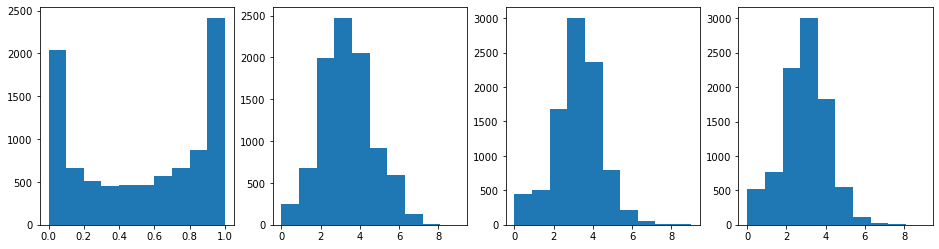

In [97]:
print('How many are susceptible?')
print(pd.value_counts(e).sort_index())

print('How many are observed?')
print(pd.value_counts(s).sort_index())

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))

ax[0].hist(e_prob)
ax[1].hist(t_disc)
ax[2].hist(c_disc)
ax[3].hist(y_disc)

plt.show()

In [98]:
x_train, y_train, s_train = X[:6000], y[:6000], s[:6000]
x_val, y_val, s_val = X[6000:7500], y[6000:7500], s[6000:7500]
x_test, y_test, s_test, e_test = X[7500:], y[7500:], s[7500:], e[7500:]
t_disc_test, c_disc_test, y_disc_test = t_disc[7500:], c_disc[7500:], y_disc[7500:]

In [99]:
model = DNMC(n_bins=N_BINS, importance_weights=importance_weights, ld=1e-2, lr=1e-2)
train_model(model, (x_train, y_train, s_train), (x_val, y_val, s_val), 100, learning_rate=LEARNING_RATE)
all_results.append(evaluate_model(model, (x_test, y_test, s_test), e_test, factors='dependent'))

Epoch  0 | Train Loss: 13.4417 | Train NLL: 4.6773 | Val Loss: 9.8124 | Val NLL: 3.8406
Epoch  1 | Train Loss: 8.3048 | Train NLL: 3.3949 | Val Loss: 7.4583 | Val NLL: 3.3050
Epoch  2 | Train Loss: 6.5449 | Train NLL: 2.8273 | Val Loss: 6.1192 | Val NLL: 2.7628
Epoch  3 | Train Loss: 5.5746 | Train NLL: 2.4737 | Val Loss: 5.4387 | Val NLL: 2.5554
Epoch  4 | Train Loss: 4.9163 | Train NLL: 2.2161 | Val Loss: 4.8640 | Val NLL: 2.3144
Epoch  5 | Train Loss: 4.4663 | Train NLL: 2.0515 | Val Loss: 4.4399 | Val NLL: 2.1568
Epoch  6 | Train Loss: 4.0730 | Train NLL: 1.9007 | Val Loss: 4.0534 | Val NLL: 1.9795
Epoch  7 | Train Loss: 3.7560 | Train NLL: 1.7707 | Val Loss: 3.7982 | Val NLL: 1.8927
Epoch  8 | Train Loss: 3.5288 | Train NLL: 1.6939 | Val Loss: 3.5376 | Val NLL: 1.7648
Epoch  9 | Train Loss: 3.3281 | Train NLL: 1.6153 | Val Loss: 3.3718 | Val NLL: 1.7116
Epoch 10 | Train Loss: 3.1339 | Train NLL: 1.5257 | Val Loss: 3.1562 | Val NLL: 1.5958
Epoch 11 | Train Loss: 2.9908 | Train NLL:

In [100]:
model = DNMC(n_bins=N_BINS, importance_weights=importance_weights, ld=3e-3, lr=1e-2)
train_model(model, (x_train, y_train, s_train), (x_val, y_val, s_val), 100, learning_rate=LEARNING_RATE)
all_results.append(evaluate_model(model, (x_test, y_test, s_test), e_test, factors='dependent'))

Epoch  0 | Train Loss: 13.1914 | Train NLL: 4.7321 | Val Loss: 9.4142 | Val NLL: 3.8795
Epoch  1 | Train Loss: 7.9584 | Train NLL: 3.4694 | Val Loss: 6.9430 | Val NLL: 3.1706
Epoch  2 | Train Loss: 6.2270 | Train NLL: 2.8409 | Val Loss: 5.8648 | Val NLL: 2.7955
Epoch  3 | Train Loss: 5.3696 | Train NLL: 2.5101 | Val Loss: 5.1959 | Val NLL: 2.5267
Epoch  4 | Train Loss: 4.8080 | Train NLL: 2.2804 | Val Loss: 4.7278 | Val NLL: 2.3255
Epoch  5 | Train Loss: 4.3407 | Train NLL: 2.0583 | Val Loss: 4.2801 | Val NLL: 2.1039
Epoch  6 | Train Loss: 3.9773 | Train NLL: 1.8904 | Val Loss: 3.9966 | Val NLL: 1.9866
Epoch  7 | Train Loss: 3.7060 | Train NLL: 1.7743 | Val Loss: 3.7156 | Val NLL: 1.8476
Epoch  8 | Train Loss: 3.4727 | Train NLL: 1.6657 | Val Loss: 3.5978 | Val NLL: 1.8506
Epoch  9 | Train Loss: 3.3019 | Train NLL: 1.6107 | Val Loss: 3.4037 | Val NLL: 1.7598
Epoch 10 | Train Loss: 3.1507 | Train NLL: 1.5472 | Val Loss: 3.2174 | Val NLL: 1.6452
Epoch 11 | Train Loss: 3.0061 | Train NLL:

In [101]:
model = DNMC(n_bins=N_BINS, importance_weights=importance_weights, ld=3e-2, lr=1e-2)
train_model(model, (x_train, y_train, s_train), (x_val, y_val, s_val), 100, learning_rate=LEARNING_RATE)
all_results.append(evaluate_model(model, (x_test, y_test, s_test), e_test, factors='dependent'))

Epoch  0 | Train Loss: 13.0191 | Train NLL: 4.6394 | Val Loss: 9.3383 | Val NLL: 3.8777
Epoch  1 | Train Loss: 7.8458 | Train NLL: 3.4167 | Val Loss: 6.9831 | Val NLL: 3.2708
Epoch  2 | Train Loss: 6.1644 | Train NLL: 2.8422 | Val Loss: 5.8412 | Val NLL: 2.8429
Epoch  3 | Train Loss: 5.2276 | Train NLL: 2.4518 | Val Loss: 5.1276 | Val NLL: 2.5466
Epoch  4 | Train Loss: 4.6598 | Train NLL: 2.2263 | Val Loss: 4.5407 | Val NLL: 2.2418
Epoch  5 | Train Loss: 4.2351 | Train NLL: 2.0460 | Val Loss: 4.1471 | Val NLL: 2.0593
Epoch  6 | Train Loss: 3.8506 | Train NLL: 1.8497 | Val Loss: 3.8410 | Val NLL: 1.9212
Epoch  7 | Train Loss: 3.6075 | Train NLL: 1.7566 | Val Loss: 3.5697 | Val NLL: 1.7841
Epoch  8 | Train Loss: 3.4198 | Train NLL: 1.6925 | Val Loss: 3.4113 | Val NLL: 1.7377
Epoch  9 | Train Loss: 3.2026 | Train NLL: 1.5795 | Val Loss: 3.1868 | Val NLL: 1.6130
Epoch 10 | Train Loss: 3.0300 | Train NLL: 1.5014 | Val Loss: 3.0317 | Val NLL: 1.5450
Epoch 11 | Train Loss: 2.9009 | Train NLL:

In [102]:
model = NMC(n_bins=N_BINS, importance_weights=importance_weights, lr=1e-2)
train_model(model, (x_train, y_train, s_train), (x_val, y_val, s_val), 100, learning_rate=LEARNING_RATE)
all_results.append(evaluate_model(model, (x_test, y_test, s_test), e_test, factors='dependent'))

Epoch  0 | Train Loss: 11.4524 | Train NLL: 4.6612 | Val Loss: 8.0586 | Val NLL: 3.7945
Epoch  1 | Train Loss: 6.6149 | Train NLL: 3.2779 | Val Loss: 5.7044 | Val NLL: 2.9744
Epoch  2 | Train Loss: 5.1153 | Train NLL: 2.6652 | Val Loss: 4.7884 | Val NLL: 2.5526
Epoch  3 | Train Loss: 4.4016 | Train NLL: 2.3036 | Val Loss: 4.2561 | Val NLL: 2.2758
Epoch  4 | Train Loss: 3.9472 | Train NLL: 2.0578 | Val Loss: 3.9252 | Val NLL: 2.1161
Epoch  5 | Train Loss: 3.6219 | Train NLL: 1.8824 | Val Loss: 3.6255 | Val NLL: 1.9454
Epoch  6 | Train Loss: 3.3758 | Train NLL: 1.7534 | Val Loss: 3.4559 | Val NLL: 1.8815
Epoch  7 | Train Loss: 3.1802 | Train NLL: 1.6541 | Val Loss: 3.2467 | Val NLL: 1.7615
Epoch  8 | Train Loss: 3.0147 | Train NLL: 1.5701 | Val Loss: 3.0640 | Val NLL: 1.6536
Epoch  9 | Train Loss: 2.8619 | Train NLL: 1.4878 | Val Loss: 2.9391 | Val NLL: 1.5964
Epoch 10 | Train Loss: 2.7584 | Train NLL: 1.4484 | Val Loss: 2.8881 | Val NLL: 1.6034
Epoch 11 | Train Loss: 2.6491 | Train NLL:

In [103]:
model = NSurv(n_bins=N_BINS, importance_weights=importance_weights, lr=1e-2)
train_model(model, (x_train, y_train, s_train), (x_val, y_val, s_val), 100, learning_rate=LEARNING_RATE)
all_results.append(evaluate_model(model, (x_test, y_test, s_test), e_test, factors='dependent'))

Epoch  0 | Train Loss: 9.6619 | Train NLL: 4.6527 | Val Loss: 7.3194 | Val NLL: 3.6637
Epoch  1 | Train Loss: 6.2966 | Train NLL: 3.1978 | Val Loss: 5.5379 | Val NLL: 2.8351
Epoch  2 | Train Loss: 5.0827 | Train NLL: 2.6026 | Val Loss: 4.7767 | Val NLL: 2.4807
Epoch  3 | Train Loss: 4.4156 | Train NLL: 2.2523 | Val Loss: 4.3025 | Val NLL: 2.2553
Epoch  4 | Train Loss: 3.9683 | Train NLL: 2.0159 | Val Loss: 4.0239 | Val NLL: 2.1558
Epoch  5 | Train Loss: 3.6423 | Train NLL: 1.8480 | Val Loss: 3.6705 | Val NLL: 1.9430
Epoch  6 | Train Loss: 3.3758 | Train NLL: 1.7080 | Val Loss: 3.3487 | Val NLL: 1.7328
Epoch  7 | Train Loss: 3.1421 | Train NLL: 1.5792 | Val Loss: 3.1314 | Val NLL: 1.6156
Epoch  8 | Train Loss: 2.9698 | Train NLL: 1.5000 | Val Loss: 2.9956 | Val NLL: 1.5650
Epoch  9 | Train Loss: 2.8348 | Train NLL: 1.4442 | Val Loss: 2.9044 | Val NLL: 1.5479
Epoch 10 | Train Loss: 2.7052 | Train NLL: 1.3855 | Val Loss: 2.7613 | Val NLL: 1.4721
Epoch 11 | Train Loss: 2.6284 | Train NLL: 

In [104]:
model = MLP(importance_weights=importance_weights, lr=1e-2)
train_model(model, (x_train, y_train, s_train), (x_val, y_val, s_val), 100, learning_rate=LEARNING_RATE)
all_results.append(evaluate_model(model, (x_test, y_test, s_test), e_test, factors='dependent'))

Epoch  0 | Train Loss: 3.6624 | Train NLL: 1.2143 | Val Loss: 2.7460 | Val NLL: 0.9991
Epoch  1 | Train Loss: 2.3054 | Train NLL: 0.8541 | Val Loss: 2.1627 | Val NLL: 0.9298
Epoch  2 | Train Loss: 1.9031 | Train NLL: 0.7994 | Val Loss: 1.8536 | Val NLL: 0.8588
Epoch  3 | Train Loss: 1.6766 | Train NLL: 0.7613 | Val Loss: 1.6466 | Val NLL: 0.8027
Epoch  4 | Train Loss: 1.5205 | Train NLL: 0.7325 | Val Loss: 1.5165 | Val NLL: 0.7792
Epoch  5 | Train Loss: 1.4037 | Train NLL: 0.7077 | Val Loss: 1.4077 | Val NLL: 0.7500
Epoch  6 | Train Loss: 1.3114 | Train NLL: 0.6856 | Val Loss: 1.3199 | Val NLL: 0.7234
Epoch  7 | Train Loss: 1.2370 | Train NLL: 0.6663 | Val Loss: 1.2453 | Val NLL: 0.6983
Epoch  8 | Train Loss: 1.1740 | Train NLL: 0.6480 | Val Loss: 1.1946 | Val NLL: 0.6884
Epoch  9 | Train Loss: 1.1203 | Train NLL: 0.6323 | Val Loss: 1.1557 | Val NLL: 0.6847
Epoch 10 | Train Loss: 1.0808 | Train NLL: 0.6255 | Val Loss: 1.1310 | Val NLL: 0.6902
Epoch 11 | Train Loss: 1.0421 | Train NLL: 

# Summary of results

In [105]:
summary = pd.DataFrame(all_results)
summary.to_csv('~/Downloads/support_results.csv', index=False)
summary

,dataset,factors,model,ld,lr,avg_test_loss,avg_test_nll,e_auc,y_ci
0,support,separate,DNMC,0.010,0.01,NaN,3.465430,0.919718,0.918621
1,support,separate,DNMC,0.003,0.01,NaN,3.473435,0.854149,0.925540
2,support,separate,DNMC,0.030,0.01,NaN,3.474421,0.744926,0.921541
3,support,separate,NMC,0.001,0.01,3.910901,3.650213,0.943959,0.705361
4,support,separate,NSurv,0.001,0.01,3.989088,3.692924,NaN,0.837757
5,support,separate,MLP,0.001,0.01,1.040912,0.982602,0.923440,NaN
6,support,overlapping,DNMC,0.010,0.01,3.639990,3.253772,0.685192,0.892703
7,support,overlapping,DNMC,0.003,0.01,3.602617,3.216988,0.567626,0.893366
8,support,overlapping,DNMC,0.030,0.01,3.697136,3.257908,0.639826,0.891946
9,support,overlapping,NMC,0.001,0.01,3.580758,3.204116,0.470909,0.894326


In [ ]:
# separate = non-overlapping subsets of predictors that predict occurrence vs time
# another way to think of it is that there are just two factors in the model, vs three

### Identification of Factors?

In [ ]:
# # Trying to work toward evidence of identification of factors
# # Phi -> E, Omega -> T

# E_mask = np.array([False] * X.shape[1])
# E_mask[E_features] = True

# T_mask = np.array([False] * X.shape[1])
# T_mask[T_features] = True

# phi_on_e = np.abs(model.phi_layers[0].kernel.numpy()).max(axis=1)[E_mask].mean()
# phi_off_e = np.abs(model.phi_layers[0].kernel.numpy()).max(axis=1)[~E_mask].mean()

# omega_on_t = np.abs(model.omega_layers[0].kernel.numpy()).max(axis=1)[T_mask].mean()
# omega_off_t = np.abs(model.omega_layers[0].kernel.numpy()).max(axis=1)[~T_mask].mean()

# print(phi_on_e, phi_off_e, omega_on_t, omega_off_t)